# Download de bibliotecas, Upload de dataset and configuração do pandas

In [113]:
# baixando as bibliotecas necessárias
!pip3 install scikit-learn
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install pandas
!pip3 install datetime
!pip3 install joblib

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import r2_score
from datetime import date, datetime
from sklearn.model_selection import cross_val_score
import joblib

In [40]:
# configurando o pandas para mostrar todas as colunas
pd.set_option('display.max_columns', None)

In [41]:
# pegando o dataset e subindo no notebook
df = pd.read_csv('Global YouTube Statistics.csv', encoding='unicode_escape')

In [42]:
# entendendo as colunas e qual o tipo delas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 995 entries, 0 to 994
Data columns (total 28 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   rank                                     995 non-null    int64  
 1   Youtuber                                 995 non-null    object 
 2   subscribers                              995 non-null    int64  
 3   video views                              995 non-null    float64
 4   category                                 949 non-null    object 
 5   Title                                    995 non-null    object 
 6   uploads                                  995 non-null    int64  
 7   Country                                  873 non-null    object 
 8   Abbreviation                             873 non-null    object 
 9   channel_type                             965 non-null    object 
 10  video_views_rank                         994 non-n

In [43]:
# verificando a quantidade de dados NaN
df.isnull().sum()

rank                                         0
Youtuber                                     0
subscribers                                  0
video views                                  0
category                                    46
Title                                        0
uploads                                      0
Country                                    122
Abbreviation                               122
channel_type                                30
video_views_rank                             1
country_rank                               116
channel_type_rank                           33
video_views_for_the_last_30_days            56
lowest_monthly_earnings                      0
highest_monthly_earnings                     0
lowest_yearly_earnings                       0
highest_yearly_earnings                      0
subscribers_for_last_30_days               337
created_year                                 5
created_month                                5
created_date 

# Pre-processamento

In [44]:
# Transformando os dados de data em datetime e depois usando a diferença entre a data de criação e o dia de hoje
df['created_month'] = df['created_month'].replace({'Jan':1,
                                                  'Feb':2,
                                                  'Mar':3,
                                                  'Apr':4,
                                                  'May':5,
                                                  'Jun':6,
                                                  'Jul':7,
                                                  'Aug':8,
                                                  'Sep':9,
                                                  'Oct':10,
                                                  'Nov':11,
                                                  'Dec':12})
df = df.sort_values(by=['created_year','created_month','created_date'])

df['created_year'] = df['created_year'].fillna(method='ffill')
df['created_month'] = df['created_month'].fillna(method='ffill')
df['created_date'] = df['created_date'].fillna(method='ffill')

year = df['created_year']
month = df['created_month']
date = df['created_date']

lista = list()
dici = dict()
for i,j,k in zip(date,month,year):
  dia = pd.to_datetime(f'{int(i)}/{int(j)}/{int(k)}', format='%d/%m/%Y')
  dici['creation'] = int((datetime.now() - dia).days)
  lista.append(dici.copy())

data = pd.DataFrame(lista)

# join do dataframe de data feito
df = df.join(data)

In [45]:
# removendo as colunas de data nao mais necessárias de data
df = df.drop(columns={'created_year','created_month','created_date'})

In [46]:
# Substituindo valores incoerentes(como uploads em zero ou lucro = 0, mesmo não sendo um canal Nonprofit) e aplicando valores médios(mediana) no lugar de NaN
df['uploads'] = df['uploads'].replace({0:df['uploads'].median()})

colunas_incoerentes = ['lowest_monthly_earnings','highest_monthly_earnings','lowest_yearly_earnings','highest_yearly_earnings','video_views_for_the_last_30_days','subscribers_for_last_30_days']
for i in colunas_incoerentes:
  df[i] = df[i].loc[(df['channel_type'] != 'Nonprofit')].replace({0:df[i].median()})
  df[i] = df[i].fillna(df[i].median())


In [47]:
# Substituindo dados NaN categóricos por valores médios(moda)
df['Country'] = df['Country'].fillna(df['Country'].mode()[0])
df['channel_type'] = df['channel_type'].fillna(df['channel_type'].mode()[0])
df

,rank,Youtuber,subscribers,video views,category,Title,uploads,Country,Abbreviation,channel_type,video_views_rank,country_rank,channel_type_rank,video_views_for_the_last_30_days,lowest_monthly_earnings,highest_monthly_earnings,lowest_yearly_earnings,highest_yearly_earnings,subscribers_for_last_30_days,Gross tertiary education enrollment (%),Population,Unemployment rate,Urban_population,Latitude,Longitude,creation
101,102,YouTube,36300000,3.010785e+09,News & Politics,YouTube,744,United States,US,Entertainment,2860.0,32.0,5.0,21103000.0,5300.0,84400.0,63300.0,1000000.0,300000.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891,6170
187,188,Michael Jackson,28200000,1.441247e+10,Music,Michael Jackson,15,United States,US,Music,242.0,54.0,59.0,158591000.0,39600.0,634400.0,475800.0,7600000.0,200000.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891,5584
519,520,Apple,17300000,1.026425e+09,Science & Technology,Apple,180,United States,US,Tech,11274.0,130.0,9.0,46484000.0,11600.0,185900.0,139500.0,2200000.0,100000.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891,3628
70,71,Ishtar Music,41400000,1.760893e+10,Trailers,Ishtar Music,4510,India,IN,Music,155.0,20.0,28.0,180942000.0,45200.0,723800.0,542800.0,8700000.0,400000.0,28.1,1.366418e+09,5.36,471031528.0,20.593684,78.962880,6309
427,428,shane,19200000,4.329121e+09,People & Blogs,shane,570,United States,US,Comedy,1705.0,114.0,22.0,2730000.0,683.0,10900.0,8200.0,131100.0,200000.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891,4085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,237,Chris Brown,25200000,1.552057e+10,Music,ChrisBrown,729,United States,NaN,Entertainment,3612215.0,NaN,NaN,64085000.0,13300.0,212700.0,159500.0,2600000.0,200000.0,NaN,NaN,NaN,NaN,NaN,NaN,5151
468,469,Good Mythical Morning,18300000,8.798045e+09,Entertainment,Goodmythicalmorning,729,United States,NaN,Entertainment,3612215.0,3305.0,NaN,64085000.0,13300.0,212700.0,159500.0,2600000.0,200000.0,NaN,NaN,NaN,NaN,NaN,NaN,3886
508,509,The Game Theorists,17600000,3.752347e+09,Gaming,TheGameTheorists,729,Australia,AU,Entertainment,3612215.0,6095.0,NaN,64085000.0,13300.0,212700.0,159500.0,2600000.0,200000.0,113.1,2.576660e+07,5.27,21844756.0,-25.274398,133.775136,3668
735,736,LEGENDA FUNK,14500000,2.440718e+09,Music,LegendaFUNK,729,Brazil,BR,Music,NaN,NaN,NaN,64085000.0,13300.0,212700.0,159500.0,2600000.0,200000.0,51.3,2.125594e+08,12.08,183241641.0,-14.235004,-51.925280,2684


# Data exploration

In [48]:
# verificando a quantidade de dados NaN
df.isnull().sum()

rank                                         0
Youtuber                                     0
subscribers                                  0
video views                                  0
category                                    46
Title                                        0
uploads                                      0
Country                                      0
Abbreviation                               122
channel_type                                 0
video_views_rank                             1
country_rank                               116
channel_type_rank                           33
video_views_for_the_last_30_days             0
lowest_monthly_earnings                      0
highest_monthly_earnings                     0
lowest_yearly_earnings                       0
highest_yearly_earnings                      0
subscribers_for_last_30_days                 0
Gross tertiary education enrollment (%)    123
Population                                 123
Unemployment 

C:\Users\55119\AppData\Local\Temp\ipykernel_5244\3822932293.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

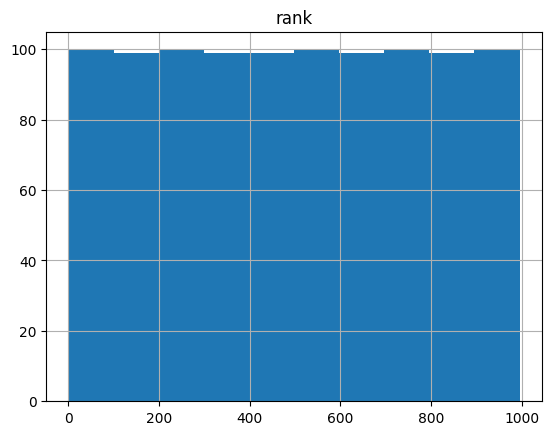

<Figure size 640x480 with 0 Axes>

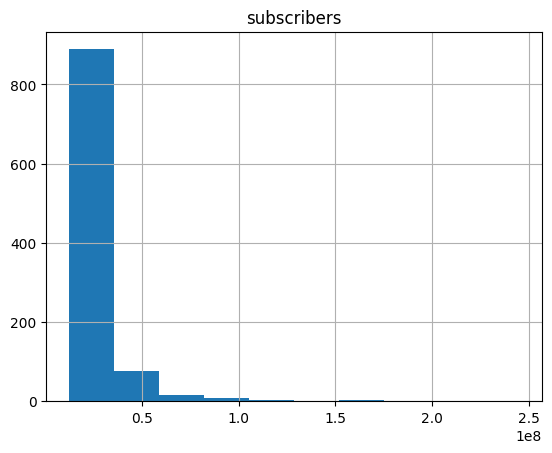

<Figure size 640x480 with 0 Axes>

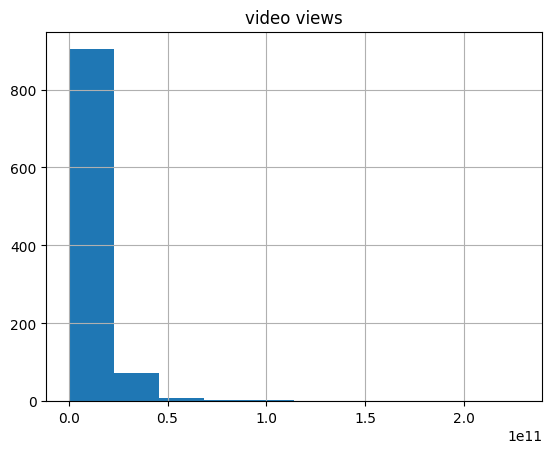

<Figure size 640x480 with 0 Axes>

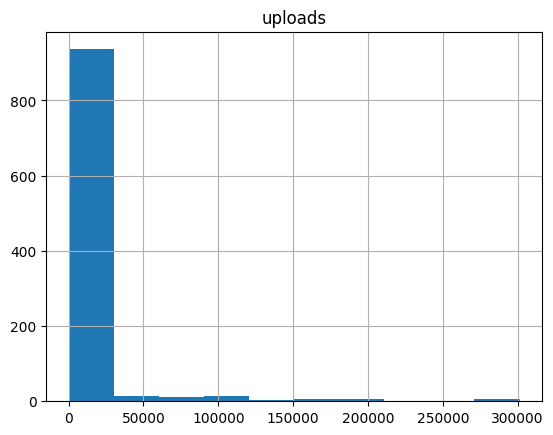

<Figure size 640x480 with 0 Axes>

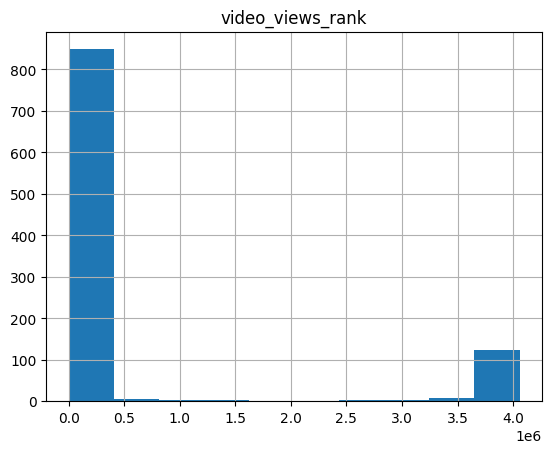

<Figure size 640x480 with 0 Axes>

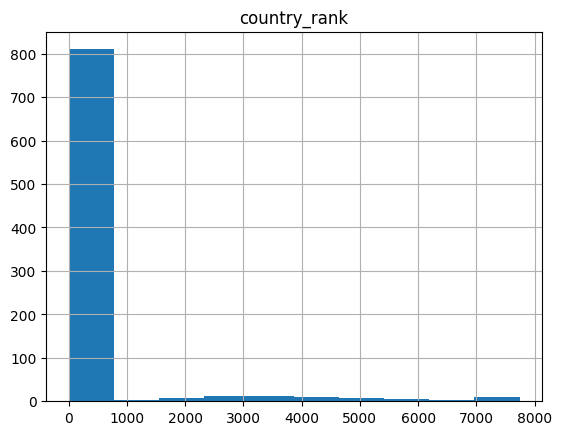

<Figure size 640x480 with 0 Axes>

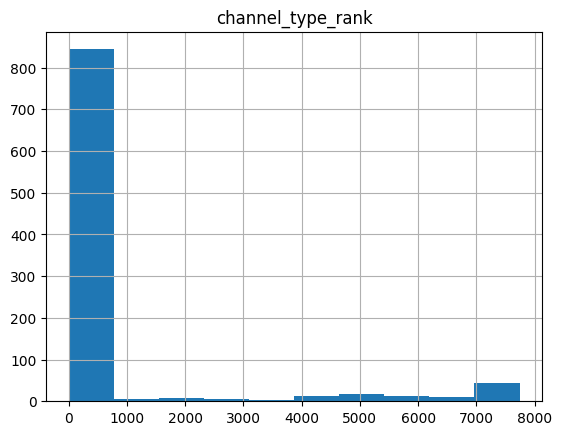

<Figure size 640x480 with 0 Axes>

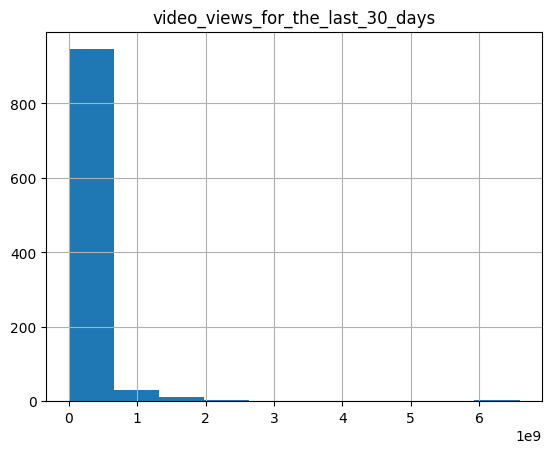

<Figure size 640x480 with 0 Axes>

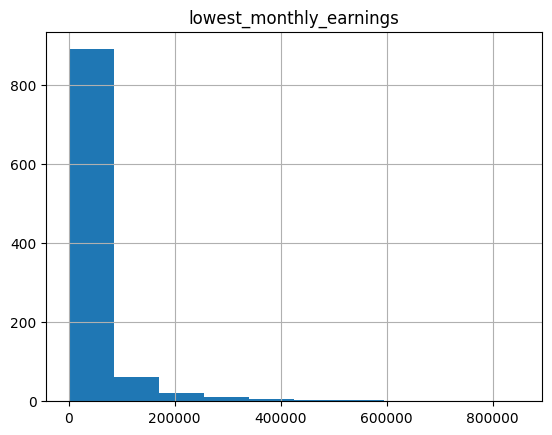

<Figure size 640x480 with 0 Axes>

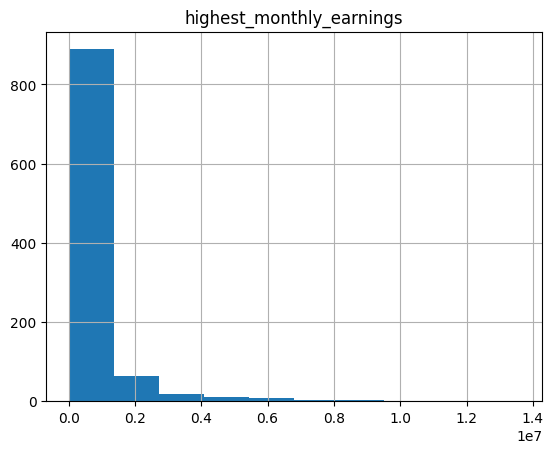

<Figure size 640x480 with 0 Axes>

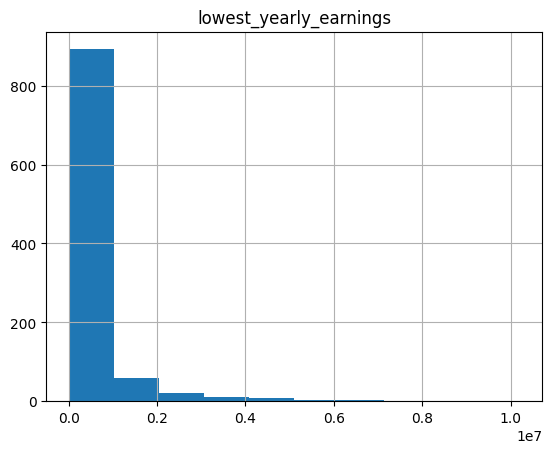

<Figure size 640x480 with 0 Axes>

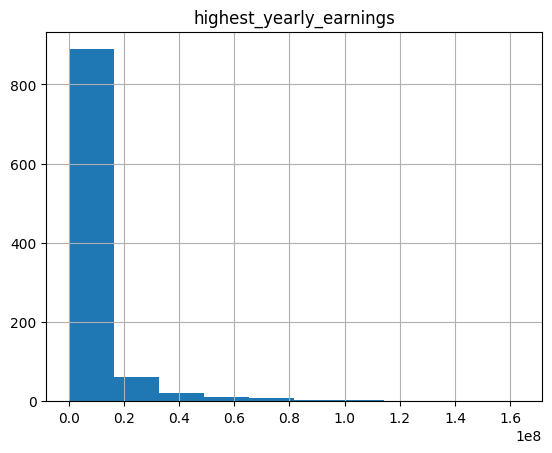

<Figure size 640x480 with 0 Axes>

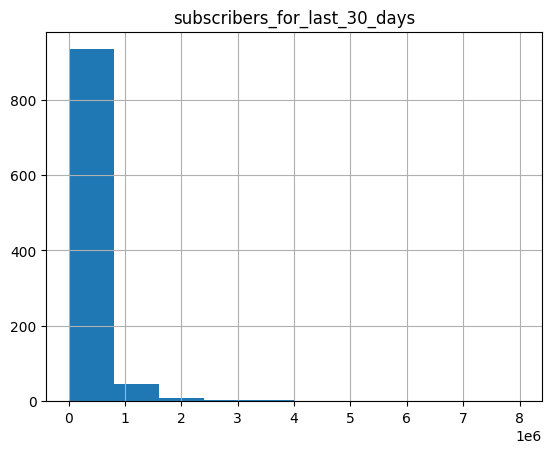

<Figure size 640x480 with 0 Axes>

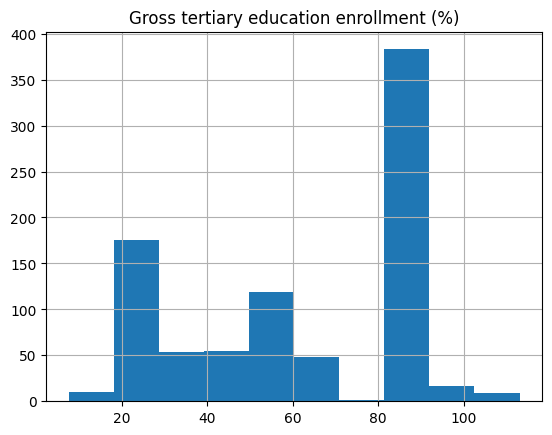

<Figure size 640x480 with 0 Axes>

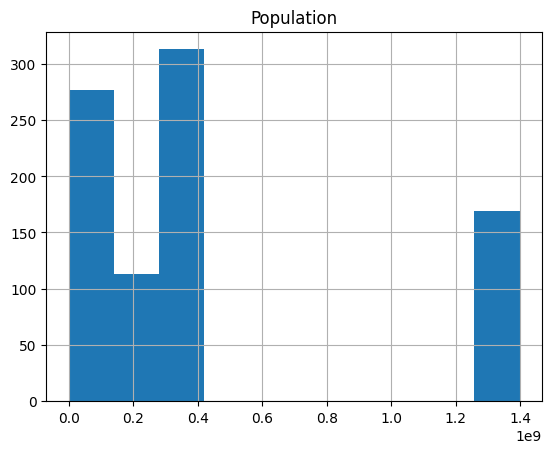

<Figure size 640x480 with 0 Axes>

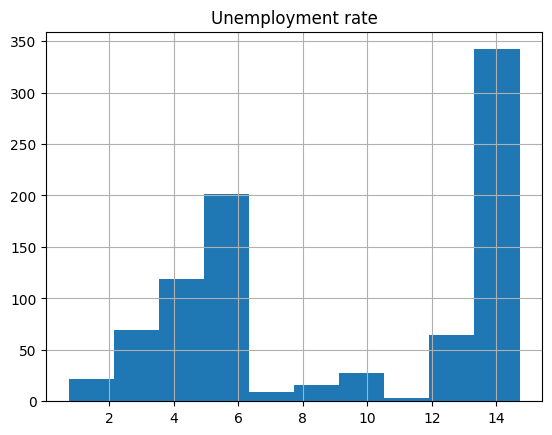

<Figure size 640x480 with 0 Axes>

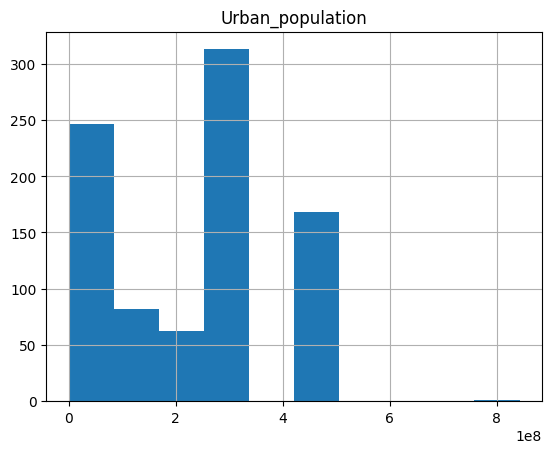

<Figure size 640x480 with 0 Axes>

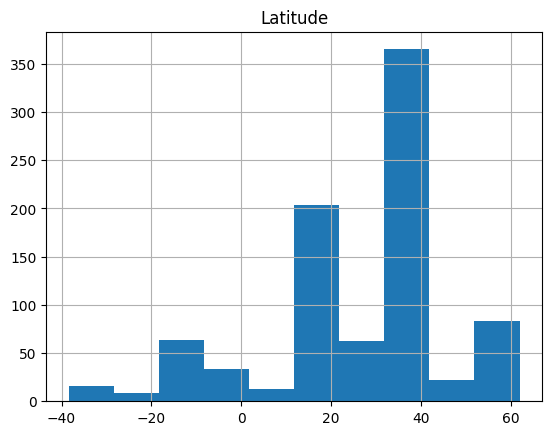

<Figure size 640x480 with 0 Axes>

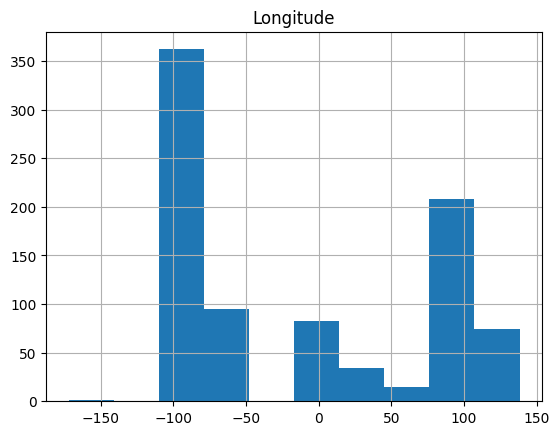

<Figure size 640x480 with 0 Axes>

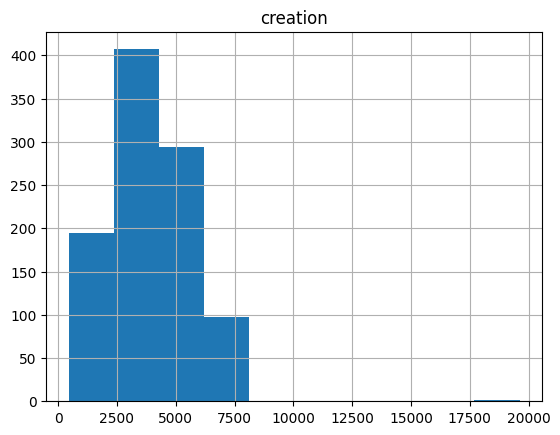

In [49]:
# entendendo a distribuição dos dados
columns_numeric = df.select_dtypes(include=['int64', 'float64']).columns.to_list()

for column in columns_numeric:
    plt.figure()
    df.hist([column])

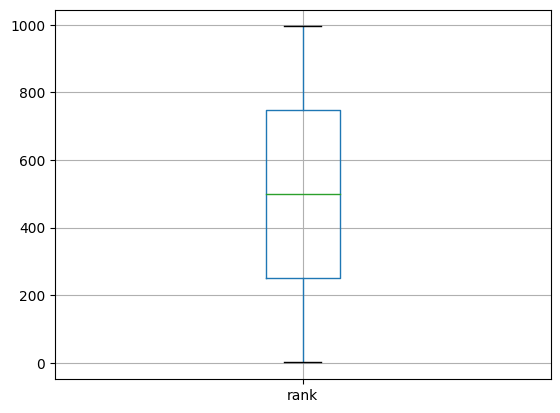

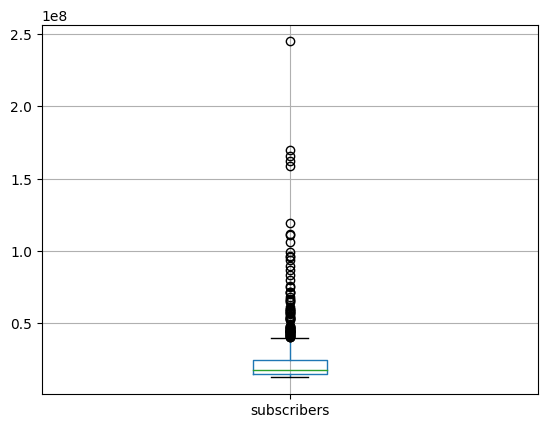

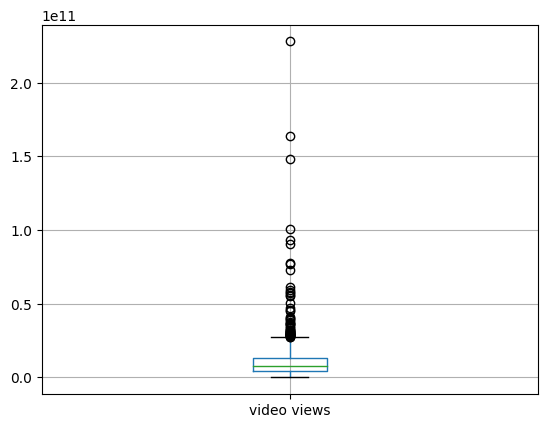

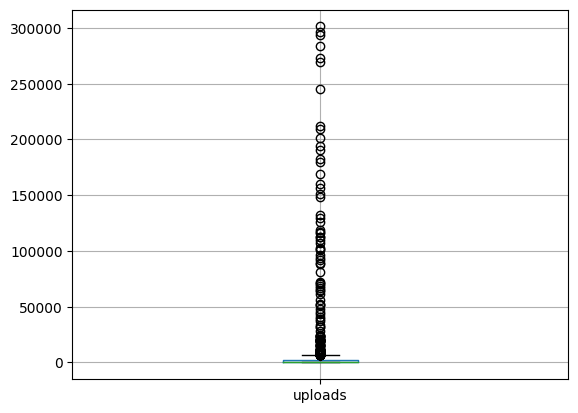

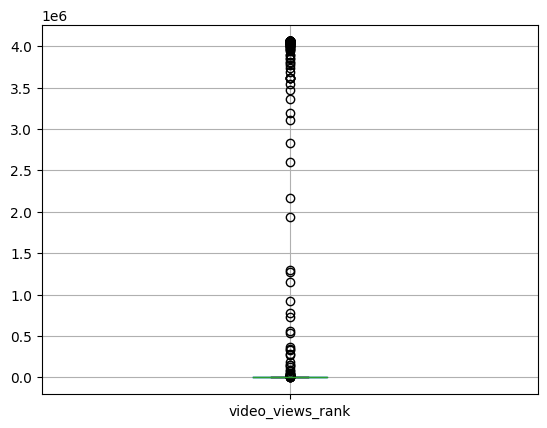

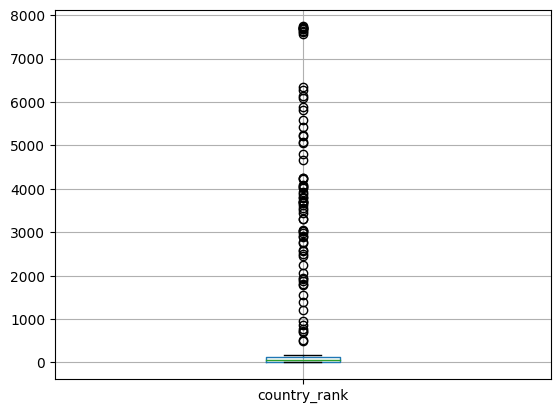

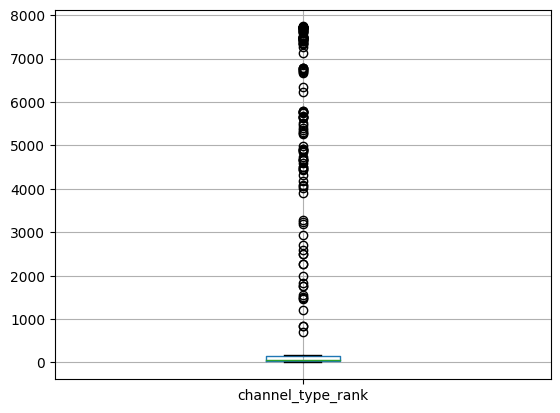

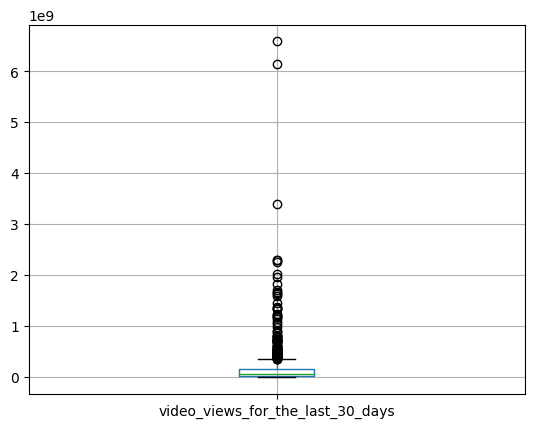

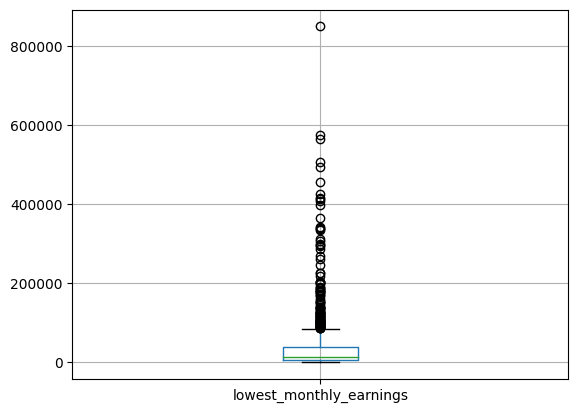

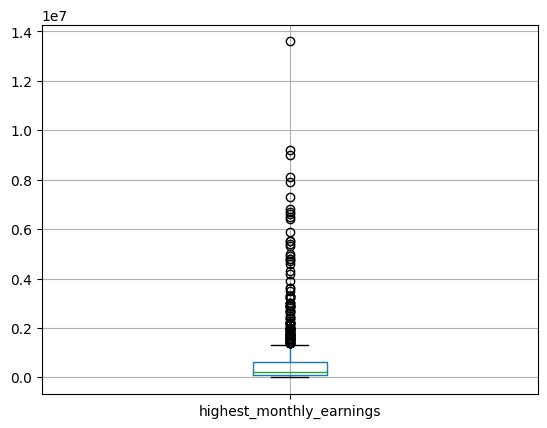

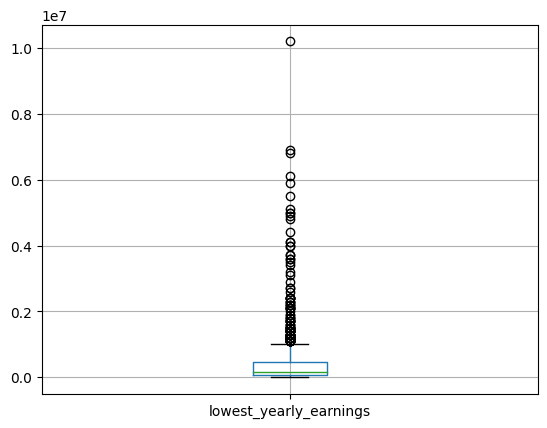

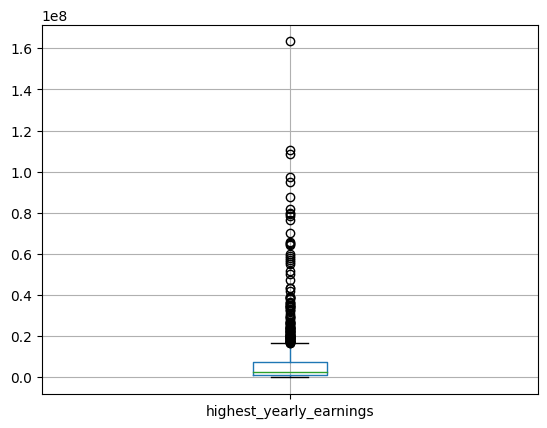

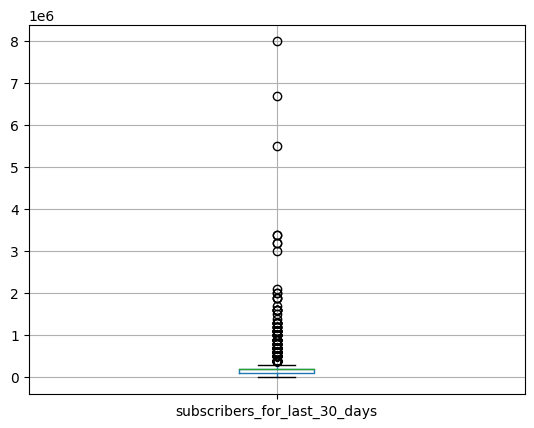

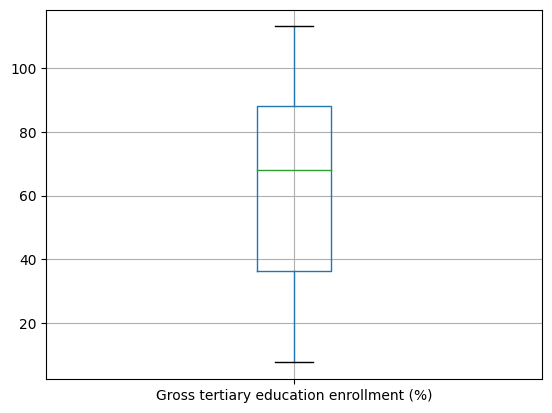

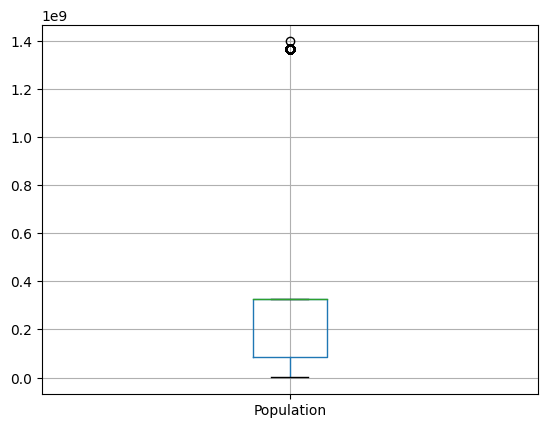

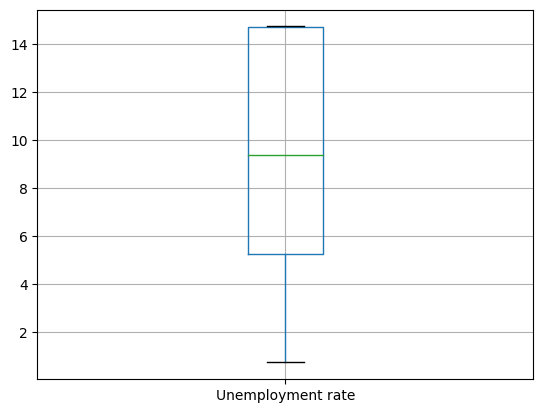

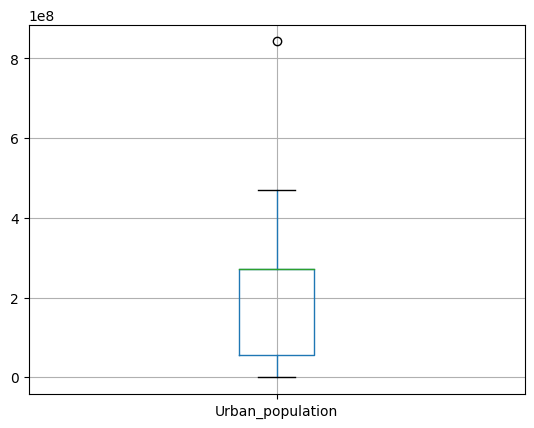

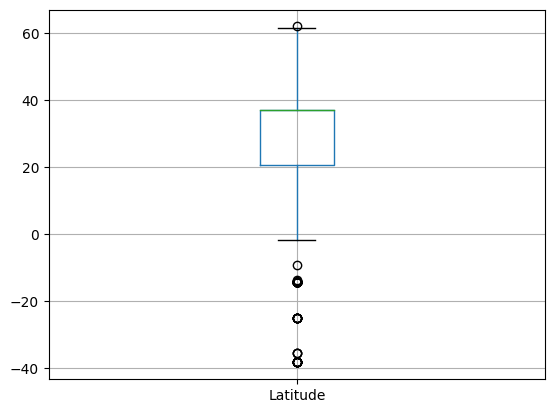

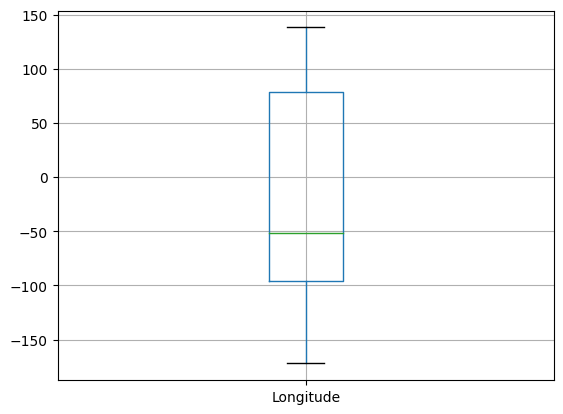

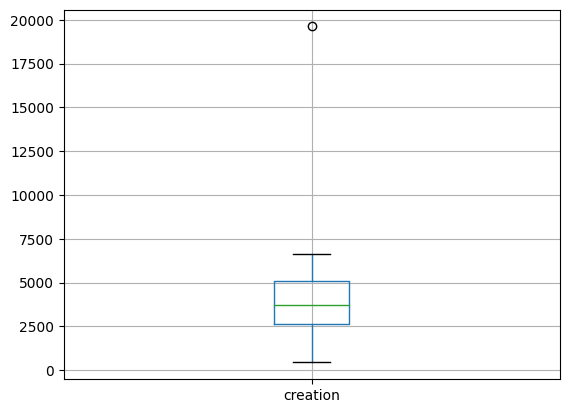

In [50]:
# procurando outliers
columns_numeric = df.select_dtypes(include=['int64', 'float64']).columns.to_list()

for column in columns_numeric:
    plt.figure()
    df.boxplot([column])

# Feature Engineering

## Matriz de correlação

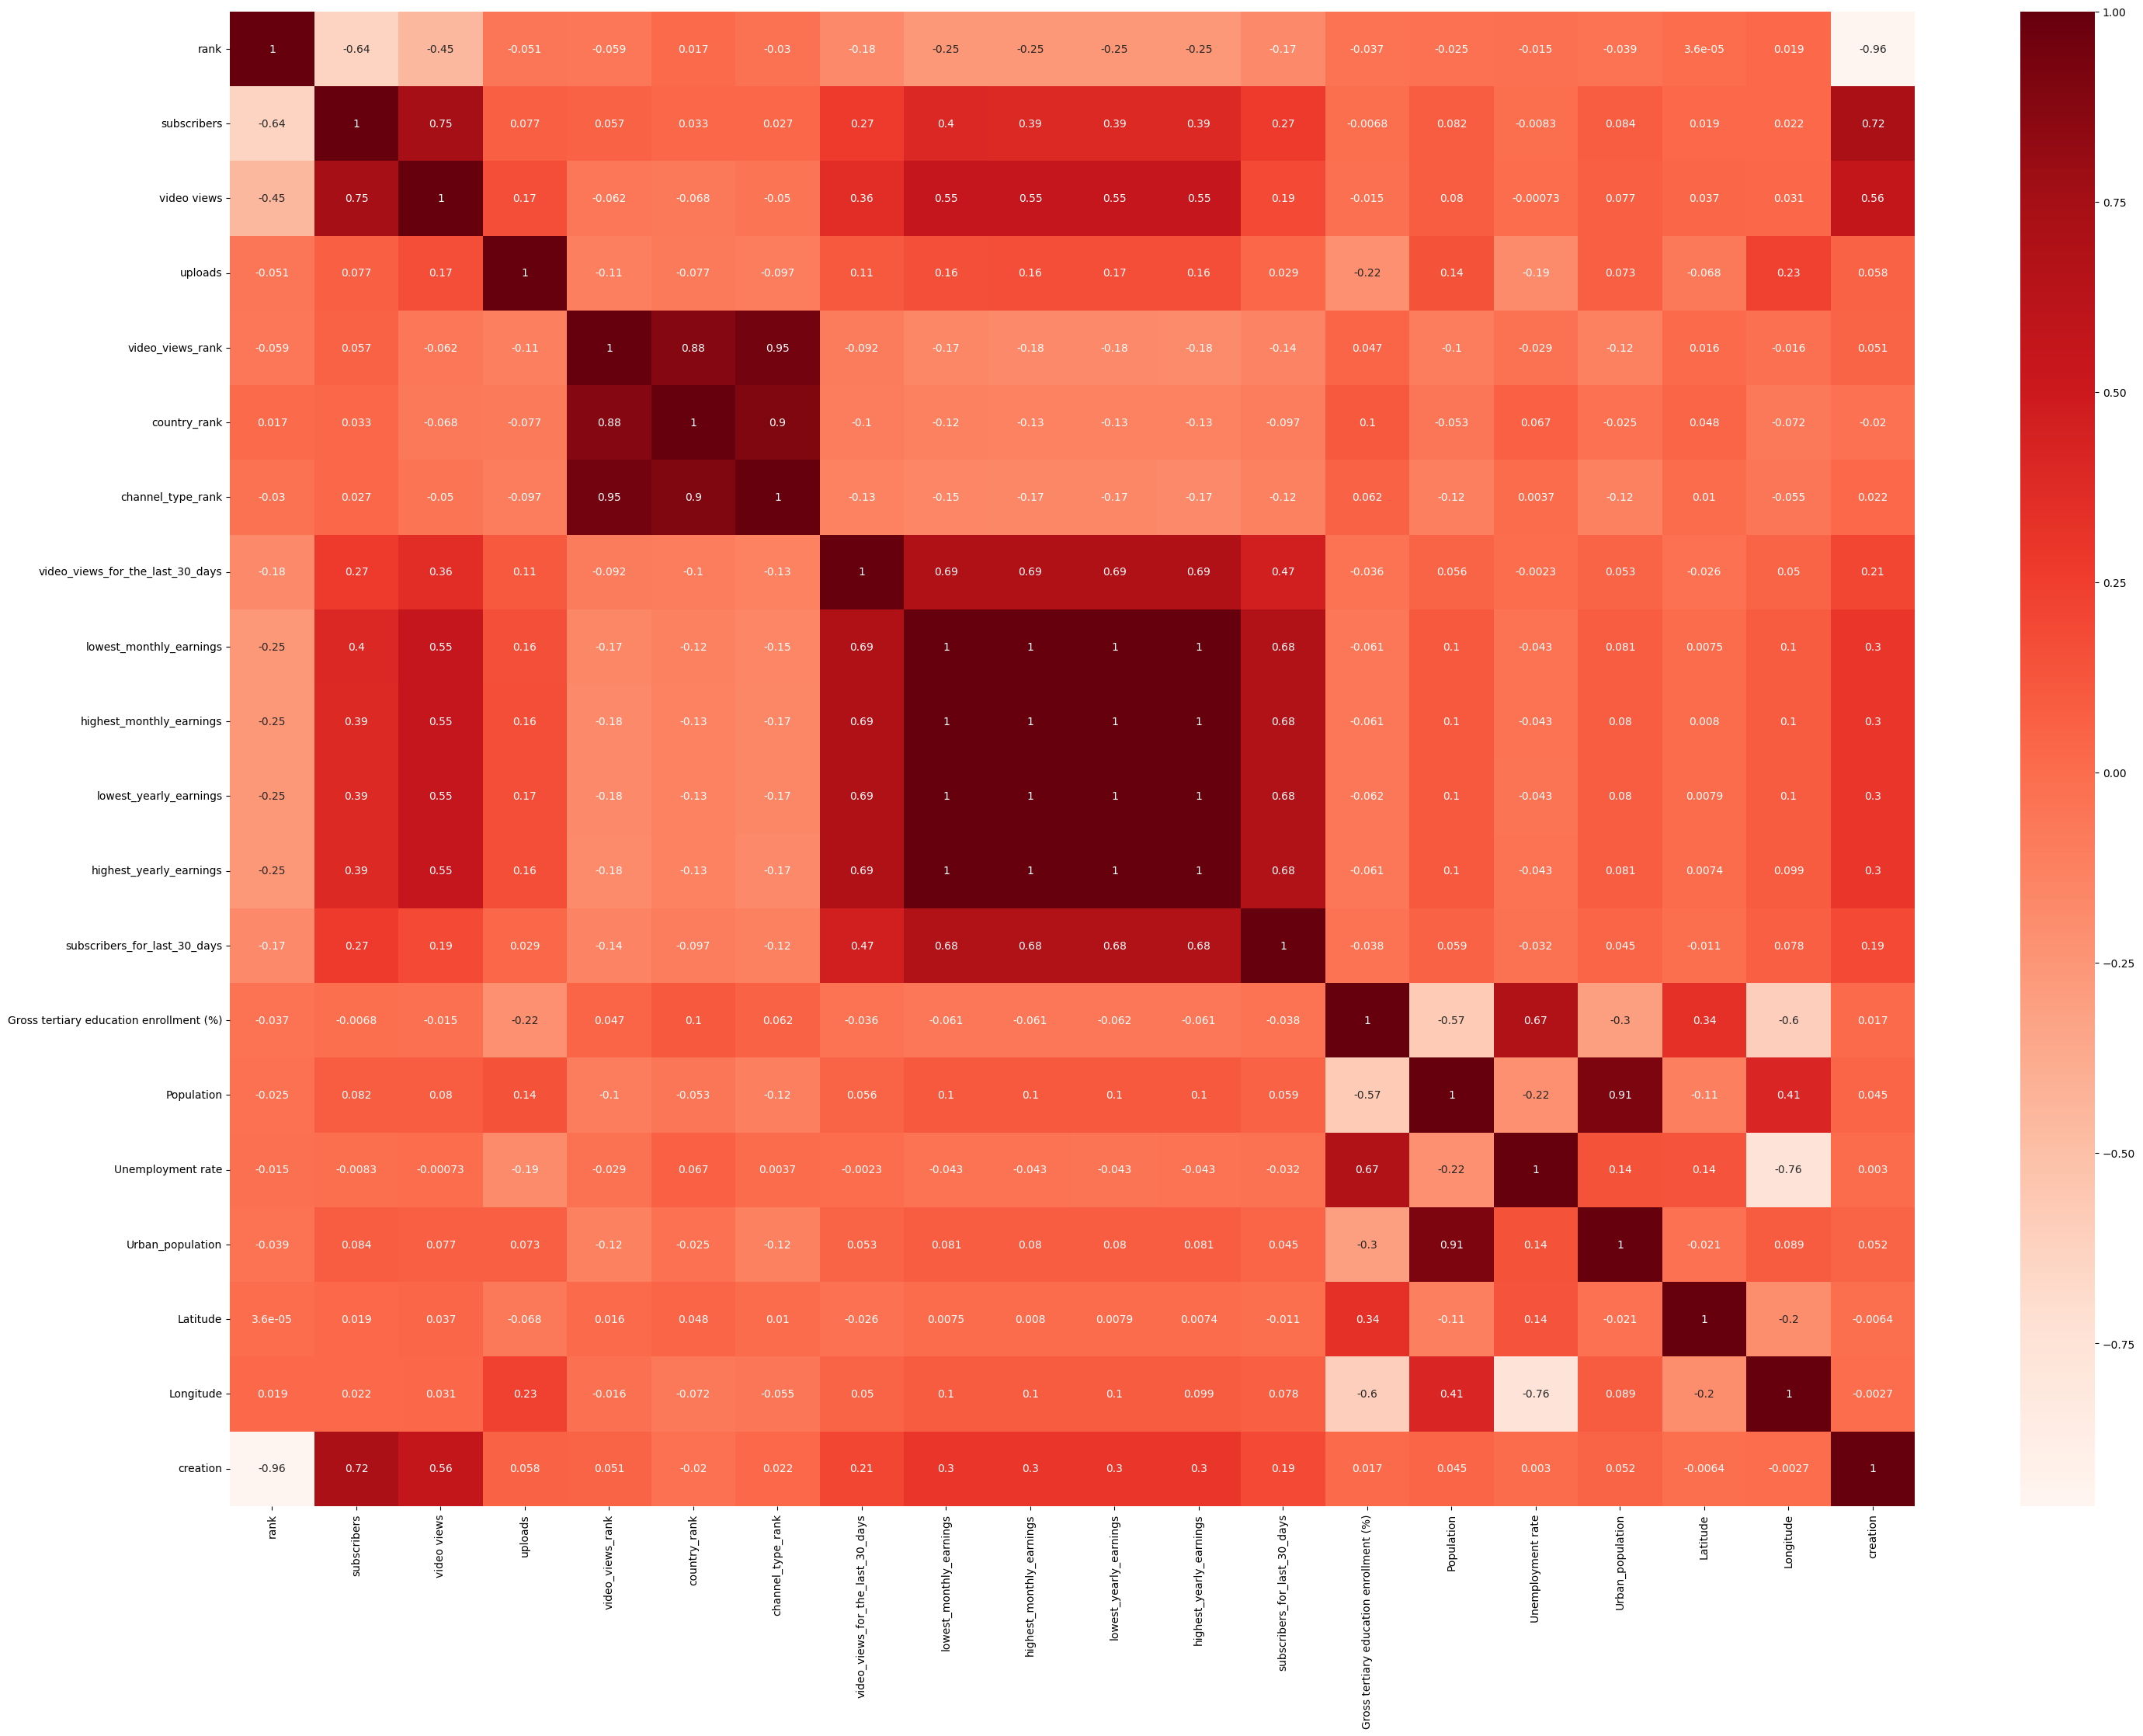

In [51]:
# verificando correlação entre colunas numericas
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.to_list()


plt.figure(figsize=(35,25))
cor = df[numeric_cols].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

obs: há alta correlação entre algumas das colunas, impossibitando de usar todas no modelo. Para solucionar isso deve-se selecionar **uma** para entrar como feature no modelo

In [52]:
# dropando colunas com alta correlação
pre_modelo = df.drop(columns={'country_rank','channel_type_rank','highest_monthly_earnings','lowest_monthly_earnings','lowest_yearly_earnings','highest_yearly_earnings','subscribers_for_last_30_days'})

## Provando correlação entre Colunas com variáveis categóricas(país) e numéricas(população, população urbana, taxa de desemprego, latitude, longitude, taxa de alunos no ensino superior)

In [53]:
df.groupby('Country')['Latitude'].unique()

Country
Afghanistan                  [33.93911]
Andorra                           [nan]
Argentina                  [-38.416097]
Australia                  [-25.274398]
Bangladesh                  [23.684994]
Barbados                    [13.193887]
Brazil                     [-14.235004]
Canada                      [56.130366]
Chile                      [-35.675147]
China                        [35.86166]
Colombia                     [4.570868]
Cuba                        [21.521757]
Ecuador                     [-1.831239]
Egypt                       [26.820553]
El Salvador                 [13.794185]
Finland                      [61.92411]
France                      [46.227638]
Germany                     [51.165691]
India                       [20.593684]
Indonesia                   [-0.789275]
Iraq                        [33.223191]
Italy                        [41.87194]
Japan                       [36.204824]
Jordan                      [30.585164]
Kuwait                       [29

In [54]:
df.groupby('Country')['Longitude'].unique()

Country
Afghanistan                   [67.709953]
Andorra                             [nan]
Argentina                    [-63.616672]
Australia                    [133.775136]
Bangladesh                    [90.356331]
Barbados                     [-59.543198]
Brazil                        [-51.92528]
Canada                      [-106.346771]
Chile                        [-71.542969]
China                        [104.195397]
Colombia                     [-74.297333]
Cuba                         [-77.781167]
Ecuador                      [-78.183406]
Egypt                         [30.802498]
El Salvador                   [-88.89653]
Finland                       [25.748151]
France                         [2.213749]
Germany                       [10.451526]
India                          [78.96288]
Indonesia                    [113.921327]
Iraq                          [43.679291]
Italy                          [12.56738]
Japan                        [138.252924]
Jordan                    

In [55]:
df.groupby('Country')['Gross tertiary education enrollment (%)'].unique()

Country
Afghanistan                   [9.7]
Andorra                       [nan]
Argentina                    [90.0]
Australia                   [113.1]
Bangladesh                   [20.6]
Barbados                     [65.4]
Brazil                       [51.3]
Canada                       [68.9]
Chile                        [88.5]
China                        [50.6]
Colombia                     [55.3]
Cuba                         [41.4]
Ecuador                      [44.9]
Egypt                        [35.2]
El Salvador                  [29.4]
Finland                      [88.2]
France                       [65.6]
Germany                      [70.2]
India                        [28.1]
Indonesia                    [36.3]
Iraq                         [16.2]
Italy                        [61.9]
Japan                        [63.2]
Jordan                       [34.4]
Kuwait                       [54.4]
Latvia                       [88.1]
Malaysia                     [45.1]
Mexico              

In [56]:
df.groupby('Country')['Unemployment rate'].unique()

Country
Afghanistan                 [11.12]
Andorra                       [nan]
Argentina                    [9.79]
Australia                    [5.27]
Bangladesh                   [4.19]
Barbados                    [10.33]
Brazil                      [12.08]
Canada                       [5.56]
Chile                        [7.09]
China                        [4.32]
Colombia                     [9.71]
Cuba                         [1.64]
Ecuador                      [3.97]
Egypt                       [10.76]
El Salvador                  [4.11]
Finland                      [6.59]
France                       [8.43]
Germany                      [3.04]
India                        [5.36]
Indonesia                    [4.69]
Iraq                        [12.82]
Italy                        [9.89]
Japan                        [2.29]
Jordan                      [14.72]
Kuwait                       [2.18]
Latvia                       [6.52]
Malaysia                     [3.32]
Mexico              

In [57]:
df.groupby('Country')['Urban_population'].unique()

Country
Afghanistan                    [9797273.0]
Andorra                              [nan]
Argentina                     [41339571.0]
Australia                     [21844756.0]
Bangladesh                    [60987417.0]
Barbados                         [89431.0]
Brazil                       [183241641.0]
Canada                        [30628482.0]
Chile                         [16610135.0]
China                        [842933962.0]
Colombia                      [40827302.0]
Cuba                           [8739135.0]
Ecuador                       [11116711.0]
Egypt                         [42895824.0]
El Salvador                    [4694702.0]
Finland                        [4716888.0]
France                        [54123364.0]
Germany                       [64324835.0]
India                        [471031528.0]
Indonesia                    [151509724.0]
Iraq                          [27783368.0]
Italy                         [42651966.0]
Japan                        [115782416.0]
Jor

In [58]:
df.groupby('Country')['Population'].unique()

Country
Afghanistan                   [38041754.0]
Andorra                              [nan]
Argentina                     [44938712.0]
Australia                     [25766605.0]
Bangladesh                   [167310838.0]
Barbados                        [287025.0]
Brazil                       [212559417.0]
Canada                        [36991981.0]
Chile                         [18952038.0]
China                       [1397715000.0]
Colombia                      [50339443.0]
Cuba                          [11333483.0]
Ecuador                       [17373662.0]
Egypt                        [100388073.0]
El Salvador                    [6453553.0]
Finland                        [5520314.0]
France                        [67059887.0]
Germany                       [83132799.0]
India                       [1366417754.0]
Indonesia                    [270203917.0]
Iraq                          [39309783.0]
Italy                         [60297396.0]
Japan                        [126226568.0]
Jor

In [59]:
# drop de colunas desnecessárias
modelo = pre_modelo.drop(columns={'Youtuber','Longitude','Latitude','Population','Unemployment rate','Urban_population','Gross tertiary education enrollment (%)','Title','Abbreviation','category','uploads','video_views_rank'})

# Modelagem

## Perfil dos dados selecionados para o modelo

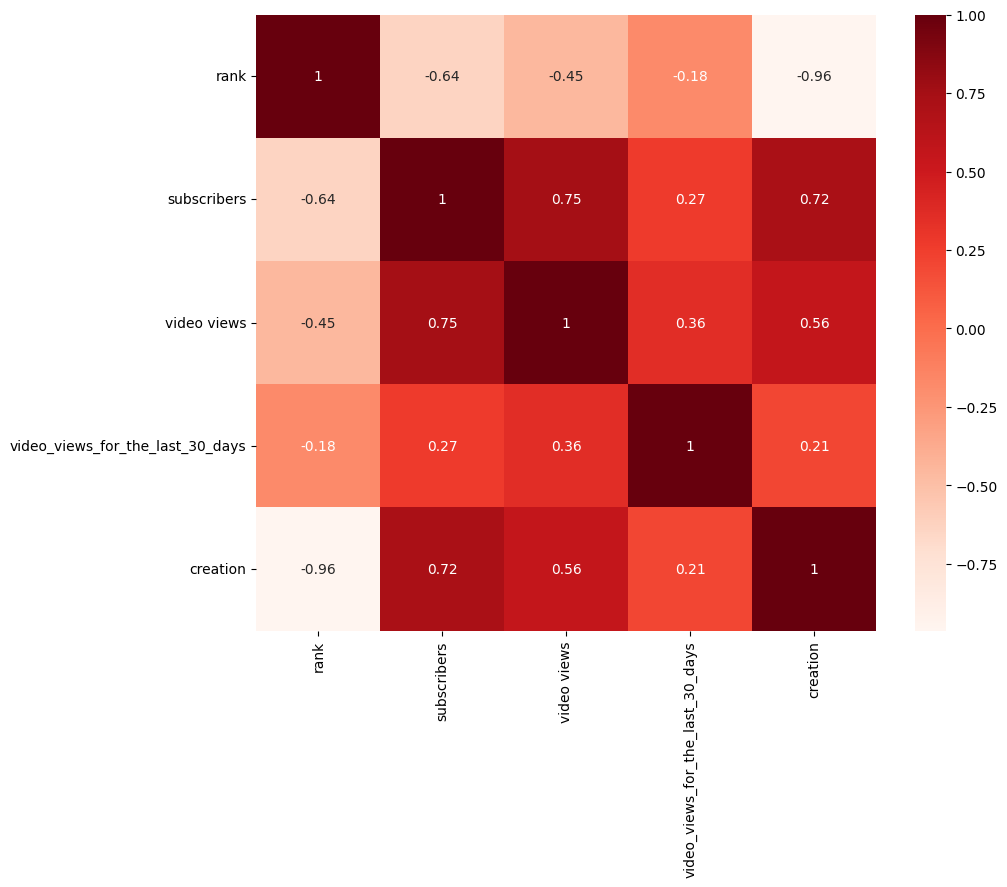

In [60]:
# verificando correlação entre colunas numericas
numeric_cols = modelo.select_dtypes(include=['int64', 'float64']).columns.to_list()


plt.figure(figsize=(10,8))
cor = modelo[numeric_cols].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

<Figure size 640x480 with 0 Axes>

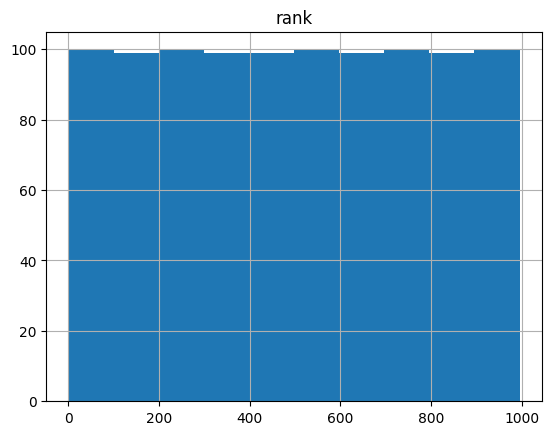

<Figure size 640x480 with 0 Axes>

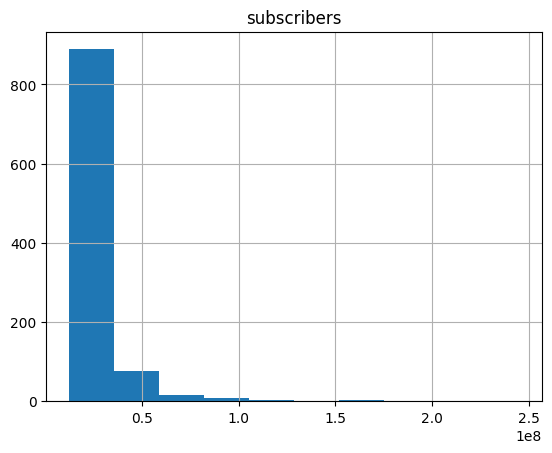

<Figure size 640x480 with 0 Axes>

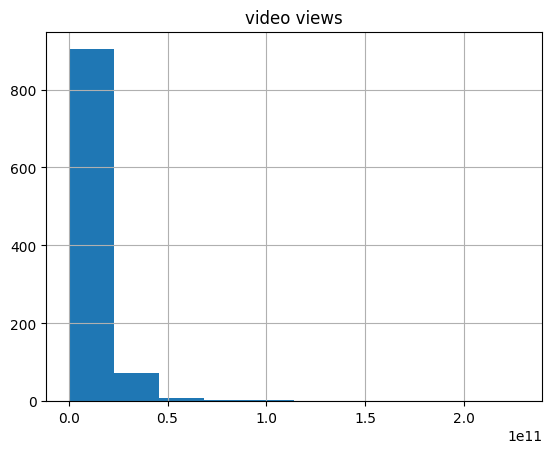

<Figure size 640x480 with 0 Axes>

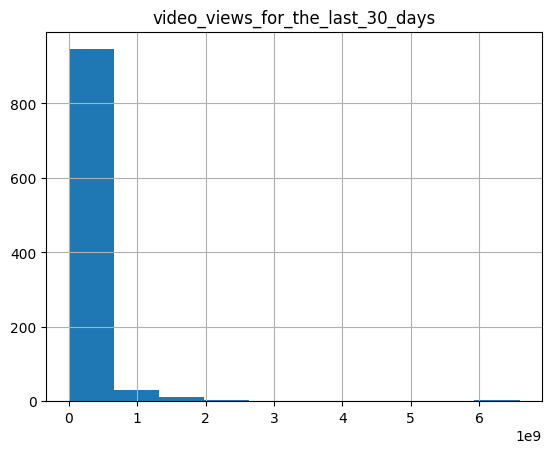

<Figure size 640x480 with 0 Axes>

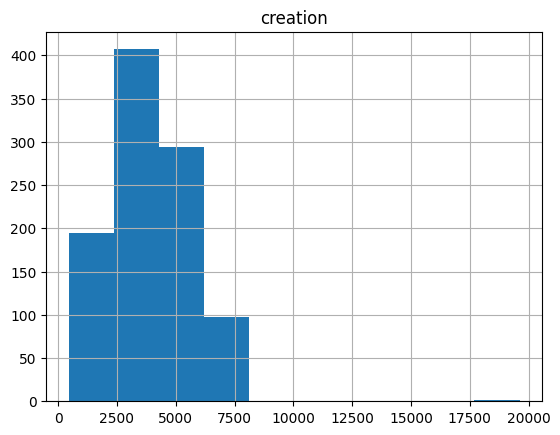

In [61]:
# entendendo a distribuição dos dados
columns_numeric = modelo.select_dtypes(include=['int64', 'float64']).columns.to_list()
for column in columns_numeric:
    plt.figure()
    modelo.hist([column])

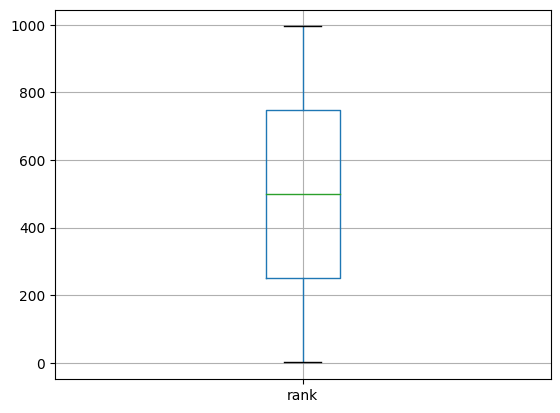

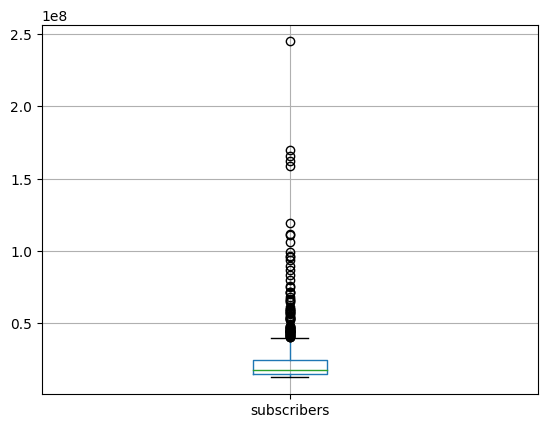

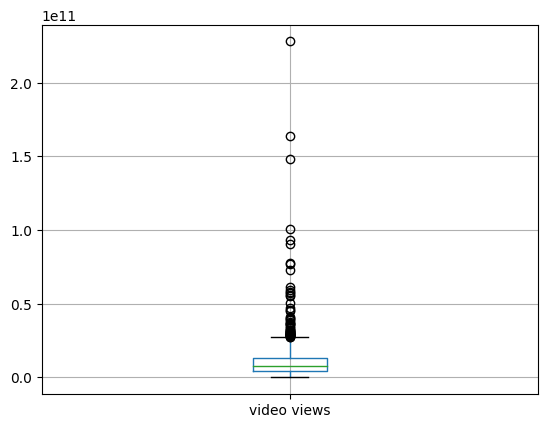

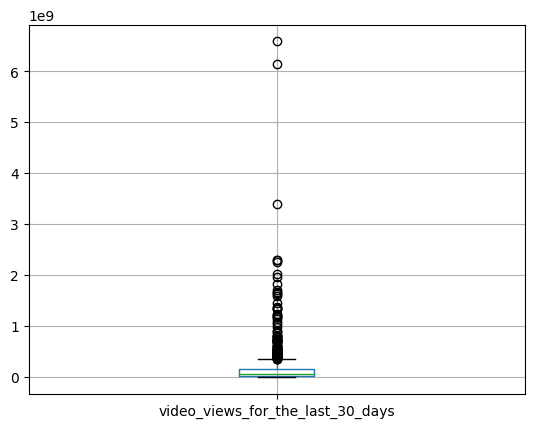

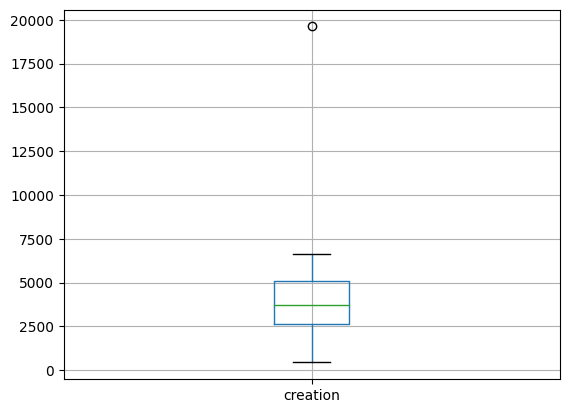

In [62]:
# verificando outliers
columns_numeric = modelo.select_dtypes(include=['int64', 'float64']).columns.to_list()

for column in columns_numeric:
    plt.figure()
    modelo.boxplot([column])

## Modelo

In [63]:
# aplicando one-hot enconding
pais = pd.get_dummies(modelo.Country)
cat = pd.get_dummies(modelo.channel_type)
join_all = modelo.join([pais,cat])
join_all = join_all.drop(columns={'Country','channel_type'})

In [118]:
join_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 995 entries, 101 to 762
Data columns (total 69 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   rank                              995 non-null    int64  
 1   subscribers                       995 non-null    int64  
 2   video views                       995 non-null    float64
 3   video_views_for_the_last_30_days  995 non-null    float64
 4   creation                          995 non-null    int64  
 5   Afghanistan                       995 non-null    bool   
 6   Andorra                           995 non-null    bool   
 7   Argentina                         995 non-null    bool   
 8   Australia                         995 non-null    bool   
 9   Bangladesh                        995 non-null    bool   
 10  Barbados                          995 non-null    bool   
 11  Brazil                            995 non-null    bool   
 12  Canada     

In [64]:
# Isolation Forest para achar outliers
model=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.05),max_features=1.0)
model.fit(join_all)

IsolationForest(contamination=0.05, n_estimators=50)

In [65]:
# marcando os outliers
join_all['anomaly']=model.predict(join_all)
outliers = join_all['anomaly'].loc[join_all['anomaly'] == -1]
outliers

63    -1
21    -1
646   -1
0     -1
29    -1
61    -1
3     -1
80    -1
4     -1
46    -1
11    -1
15    -1
455   -1
56    -1
26    -1
128   -1
192   -1
478   -1
612   -1
882   -1
116   -1
64    -1
406   -1
860   -1
206   -1
143   -1
702   -1
24    -1
136   -1
10    -1
40    -1
690   -1
32    -1
295   -1
367   -1
174   -1
884   -1
942   -1
8     -1
458   -1
902   -1
286   -1
13    -1
241   -1
199   -1
495   -1
75    -1
598   -1
649   -1
738   -1
Name: anomaly, dtype: int32

In [66]:
# removendo os outliers com threshold de 5%
join_all = join_all.drop(columns={'anomaly'})
join_all.drop(outliers.index)


,rank,subscribers,video views,video_views_for_the_last_30_days,creation,Afghanistan,Andorra,Argentina,Australia,Bangladesh,Barbados,Brazil,Canada,Chile,China,Colombia,Cuba,Ecuador,Egypt,El Salvador,Finland,France,Germany,India,Indonesia,Iraq,Italy,Japan,Jordan,Kuwait,Latvia,Malaysia,Mexico,Morocco,Netherlands,Pakistan,Peru,Philippines,Russia,Samoa,Saudi Arabia,Singapore,South Korea,Spain,Sweden,Switzerland,Thailand,Turkey,Ukraine,United Arab Emirates,United Kingdom,United States,Venezuela,Vietnam,Animals,Autos,Comedy,Education,Entertainment,Film,Games,Howto,Music,News,Nonprofit,People,Sports,Tech,anomaly
101,102,36300000,3.010785e+09,21103000.0,6170,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,1
187,188,28200000,1.441247e+10,158591000.0,5584,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,1
519,520,17300000,1.026425e+09,46484000.0,3628,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,1
70,71,41400000,1.760893e+10,180942000.0,6309,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,1
427,428,19200000,4.329121e+09,2730000.0,4085,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,237,25200000,1.552057e+10,64085000.0,5151,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,1
468,469,18300000,8.798045e+09,64085000.0,3886,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,1
508,509,17600000,3.752347e+09,64085000.0,3668,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,

In [67]:
# divide a coluna target das features
y = join_all['rank']
x = join_all.drop(columns={y.name})

In [68]:
# separa em treino e teste
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [69]:
# treinando o modelo
clf = linear_model.Lasso(alpha=0.1)
clf.fit(X_train, y_train)

Lasso(alpha=0.1)

In [127]:
# teste de cross validation para ver se está com overfitting
scores = cross_val_score(clf, x, y, cv=5)
scores

array([0.70512371, 0.97838905, 0.9818742 , 0.97148731, 0.9754177 ])

se tá consistente tá beleza

In [70]:
# faz a predição
y_pred = clf.predict(X_test)

In [71]:
# teste de r2 para testar a acurácia
r2 = r2_score(y_test, y_pred)
r2

0.9585770382232224

In [117]:
# sobe o modelo para os arquivos
joblib.dump(clf, 'modelo.pkl')

['modelo.pkl']

In [108]:
# Prepara uma entrada para predição
data = pd.DataFrame([['10000000', '6275', '10000000', '5000000','United States','Games']])
data.columns = ['video_views_for_the_last_30_days','creation','subscribers','video views','Country','channel_type']
data[data['Country']] = 1
data[data['channel_type']] = 1

In [109]:
# Criação dos dataframe com os outros dados do one hot encoding
columns = list(set(join_all.columns) - set(data.columns))
zero_array = []
for i in range(len(columns)):
  zero_array.append(0)
data2 = pd.DataFrame([zero_array])
data2.columns = columns

# Join dos dois dataframes
data_prediction = data.join(data2)

# tirando o y e colunas do one-hot
columns_to_drop = ['Country','channel_type','rank']
data_prediction = data_prediction.drop(columns=columns_to_drop)
data_prediction = data_prediction[x.columns]


In [110]:
data_prediction

,subscribers,video views,video_views_for_the_last_30_days,creation,Afghanistan,Andorra,Argentina,Australia,Bangladesh,Barbados,Brazil,Canada,Chile,China,Colombia,Cuba,Ecuador,Egypt,El Salvador,Finland,France,Germany,India,Indonesia,Iraq,Italy,Japan,Jordan,Kuwait,Latvia,Malaysia,Mexico,Morocco,Netherlands,Pakistan,Peru,Philippines,Russia,Samoa,Saudi Arabia,Singapore,South Korea,Spain,Sweden,Switzerland,Thailand,Turkey,Ukraine,United Arab Emirates,United Kingdom,United States,Venezuela,Vietnam,Animals,Autos,Comedy,Education,Entertainment,Film,Games,Howto,Music,News,Nonprofit,People,Sports,Tech,anomaly
0,10000000,5000000,10000000,6275,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [111]:
if clf.predict(data_prediction) < 1:
    prediction = 1
else:
    prediction = clf.predict(data_prediction)
prediction

array([2.279238])